In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import exp, inf, tanh
from numpy import mean, std
from scipy.stats import norm
from scipy.signal import savgol_filter

In [2]:
class ChangePointSequence:
    def __init__(self, N, mean, standard_deviation, change_point_position):
        self.N = N
        self.counter = -1
        self.mean = mean
        self.standard_deviation = standard_deviation
        self.change_point_position = change_point_position
        self.sequence = []
        
    def __iter__(self):
        return self
    
    def __next__(self):
        pass

    
class NoChangePoint(ChangePointSequence):
    '''
    Потоковая генерация случайной последовательности без разладки.
    '''
    def __init__(self, N, mean, standard_deviation):
        super().__init__(N, mean, standard_deviation, 0)
        
    def __next__(self):
        if self.counter < self.N:
            self.counter += 1
            new_element_sequence = float(norm.rvs(loc=self.mean, scale=self.standard_deviation, size=1))             
            self.sequence.append(new_element_sequence)
            return new_element_sequence
        else:
            raise StopIteration
    

class ChagePointMean(ChangePointSequence):
    '''
    Потоковая генерация случайной последовательности с разладкой в М.О.
    '''
    def __init__(self, N, mean, standard_deviation, change_point_position, mean_change):
        super().__init__(N, mean, standard_deviation, change_point_position)
        self.mean_change = mean_change
        
    def __next__(self):
        if self.counter < self.N:
            
            self.counter += 1
            
            new_element_sequence = float(norm.rvs(loc=self.mean, scale=self.standard_deviation, size=1)) \
            if self.counter <= self.change_point_position \
            else float(norm.rvs(loc=(self.mean+self.mean_change), scale=self.standard_deviation, size=1))
            
            self.sequence.append(new_element_sequence)
            return new_element_sequence
        
        else:
            raise StopIteration
            
            
class ChagePointMeanDynamic(ChangePointSequence):
    '''
    Потоковая генерация случайной последовательности с разладкой в М.О.
    '''
    def __init__(self, N, mean, standard_deviation, change_point_position, mean_change):
        super().__init__(N, mean, standard_deviation, change_point_position)
        self.mean_change = mean_change
        
    def __next__(self):
        if self.counter < self.N:
            
            self.counter += 1
            
            new_element_sequence = float(norm.rvs(loc=self.mean, scale=self.standard_deviation, size=1)) \
            if self.counter <= self.change_point_position \
            else float(norm.rvs(loc=(self.mean+self.mean_change*(self.counter-self.change_point_position)),
                                scale=self.standard_deviation,
                                size=1))
            
            self.sequence.append(new_element_sequence)
            return new_element_sequence
            
        else:
            raise StopIteration
            
            
class ChagePointDispersion(ChangePointSequence):
    '''
    Потоковая генерация случайной последовательности с разладкой в дисперсии
    '''
    def __init__(self, N, mean, standard_deviation, change_point_position, standard_deviation_change):
        super().__init__(N, mean, standard_deviation, change_point_position)
        self.standard_deviation_change = standard_deviation_change
        
    def __next__(self):
        if self.counter < self.N:
            
            self.counter += 1
            
            new_element_sequence = float(norm.rvs(loc=self.mean, scale=self.standard_deviation, size=1)) \
            if self.counter <= self.change_point_position \
            else float(norm.rvs(loc=self.mean, scale=(self.standard_deviation+self.standard_deviation_change), size=1))
            
            self.sequence.append(new_element_sequence)
            return new_element_sequence
        
        else:
            raise StopIteration    

In [3]:
# Алгоритм кусюм
def algorithm_CUSUM_bootstrap(seq, confidence_level=95, number_bootstrap_samples=1000):
    for i in seq:
        pass
    sequence = seq.sequence
    
    mean_y = np.mean(sequence)

    CUSUM = np.asarray([yi - mean_y for yi in sequence])
    CUSUM = np.cumsum(CUSUM)

    CUSUM_max = np.max(CUSUM)
    CUSUM_min = np.min(CUSUM)
    CUSUM_diff = CUSUM_max - CUSUM_min

    count = 0
    for i in range(number_bootstrap_samples):
        new_y = np.random.permutation(sequence)
        new_CUSUM = np.asarray([yi - mean_y for yi in new_y])
        new_CUSUM = np.cumsum(new_CUSUM)

        new_CUSUM_max = np.max(new_CUSUM)
        new_CUSUM_min = np.min(new_CUSUM)
        new_CUSUM_diff = new_CUSUM_max - new_CUSUM_min
        if new_CUSUM_diff < CUSUM_diff:
            count += 1

    confidence_level_calc = (count / number_bootstrap_samples) * 100
    if confidence_level_calc > confidence_level:
        abs_CUSUM = np.fabs(CUSUM)
        CUSUM_max = np.max(abs_CUSUM)
        change_point = int(np.where(abs_CUSUM == CUSUM_max)[0]) 
#         print('Точка разладки:', change_point)
        return change_point
    else: 
        return -1


# Алгоритм Боровкова
def algorithm_change_point_Q(seq):
    for i in seq:
        pass
    
    f_1 = seq.sequence
    S_1_m = np.cumsum(f_1)
    
    f_2 = [y ** 2 for y in f_1]
    S_2_m = np.cumsum(f_2)
    
    Q1 = []
    Q2 = []
    n = len(f_1)
    
    for t in range(n):
        sum_Q = 0
        for i in range(0, t+1):
            sum_Q += (f_1[i] - S_1_m[t]/t) ** 2
            
        for i in range(t+1, n):
            sum_Q += (f_1[i] - (S_1_m[n-1]-S_1_m[t])/(n-t)) ** 2
        
        Q1.append(sum_Q)
        
    for t in range(n):
        sum_Q = 0
        for i in range(0, t+1):
            sum_Q += (f_2[i] - S_2_m[t]/t) ** 2
            
        for i in range(t+1, n):
            sum_Q += (f_2[i] - (S_2_m[n-1]-S_2_m[t])/(n-t)) ** 2
        
        Q2.append(sum_Q)
        
    Q = [q1+q2 for q1,q2 in zip(Q1,Q2)]
    
    min_Q = np.min(Q)
    change_point = int(np.where(Q == min_Q)[0]) # +1 ?
    return change_point

# Алгоритм, основанный на информационном подходе
def algorithm_fa(seq, type_cp='mean'):
    for i in seq:
        pass
    sequence = seq.sequence
    
    n = len(sequence)
    tau = np.arange(1,n)
    lmbd = 2*np.log(n) #Bayesian Information Criterion
    eps = 1.e-8 #to avoid zeros in denominator
    
    if type_cp =="mean":
        mu0 = np.mean(sequence)
        s0 = np.sum((sequence-mu0)**2)
        s1 = np.asarray([np.sum((sequence[0:i]-np.mean(sequence[0:i]))**2) for i in range(1,n)])
        s2 = np.asarray([np.sum((sequence[i:]-np.mean(sequence[i:]))**2) for i in range(1,n)])
        R  = s0-s1-s2
        G  = np.max(R)
        taustar = int(np.where(R==G)[0]) 
        sd1 = np.std(sequence[0:taustar-1])
        sd2 = np.std(sequence[taustar-1:])
        var = ( taustar*sd1**2 + (n-taustar)*sd2**2 ) / n
        criterion = lmbd # var*lmbd
         
    elif type_cp =="var":
        std0 = np.std(sequence)
        std1 = np.asarray([np.std(sequence[0:i]) for i in range(1,n)],dtype=float) + eps
        std2 = np.asarray([np.std(sequence[i:]) for i in range(1,n)],dtype=float) + eps
        R = n*np.log(std0) - tau*np.log(std1) - (n-tau)*np.log(std2)
        G  = np.max(R)
        taustar = int(np.where(R==G)[0])
        criterion = lmbd
        
    if 2*G >= criterion:
        return taustar
    else:
        return -1

    
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = np.array(data)[indices.astype(int)]
    return samples

# Варьируем среднеквадратичное (1)  для Wв

In [85]:
%%time
def calculate_W(k, change_point_list, CP=600):
    left = CP - k
    right = CP + k 
    lst_freq = [x for x in change_point_list if left <= x <= right]
    return len(lst_freq) / len(change_point_list)

# Показатели W1, W2, W3, W4
lst_W1 = []
lst_W2 = []
lst_W3 = []
lst_W4 = []

# Показатели K1, K2, K3, K4
k1 = 5
k2 = 10
k3 = 15
k4 = 20

# При различных значениях сигма
lst_sig = [a/20 for a in range(10, 91, 10)]
len_timeseries = 600
cpp = 300
N = 250
N_bootstrap = 10000 

for sig in lst_sig:
    # Для алгоритма кусьюм
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=len_timeseries,
            mean=1, 
            standard_deviation=sig,
            change_point_position=cpp,
            mean_change=2
        )

        result = algorithm_CUSUM_bootstrap(seq=sequence)
        lst.append(result)
        
    W_1 = 0
    W_2 = 0
    W_3 = 0
    W_4 = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):       
        W_1 += calculate_W(k1, sample, CP=cpp)
        W_2 += calculate_W(k2, sample, CP=cpp)
        W_3 += calculate_W(k3, sample, CP=cpp)
        W_4 += calculate_W(k4, sample, CP=cpp)
        
    W_1 = W_1 / N_bootstrap
    W_2 = W_2 / N_bootstrap
    W_3 = W_3 / N_bootstrap
    W_4 = W_4 / N_bootstrap
    
    lst_W1.append(W_1)
    lst_W2.append(W_2)
    lst_W3.append(W_3)
    lst_W4.append(W_4)

Wall time: 23min 12s
Parser   : 127 ms


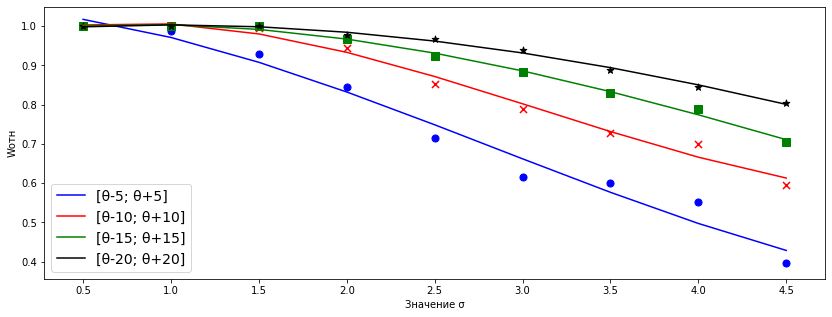

In [86]:
plt.figure(figsize=(14,5))
plt.ylabel('Wотн')
plt.xlabel('Значение σ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_W1, len(lst_sig), 3),
             color='blue',
             label='[θ-5; θ+5]')
plt.scatter(lst_sig, lst_W1, color='blue', s=50, marker='o')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_W2, len(lst_sig), 3),
             color='red',
             label='[θ-10; θ+10]')
plt.scatter(lst_sig, lst_W2, color='red', s=50, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_W3, len(lst_sig), 3),
             color='green',
             label='[θ-15; θ+15]')
plt.scatter(lst_sig, lst_W3, color='green', s=50, marker='s')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_W4, len(lst_sig), 3),
             color='black',
             label='[θ-20; θ+20]')
plt.scatter(lst_sig, lst_W4, color='black', s=50, marker='*')

plt.legend(fontsize=14) 
plt.show()

In [87]:
%%time
# Показатели W1, W2, W3, W4
lst_W1 = []
lst_W2 = []
lst_W3 = []
lst_W4 = []

for sig in lst_sig:
    # Для алгоритма FA
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=len_timeseries,
            mean=1, 
            standard_deviation=sig,
            change_point_position=cpp,
            mean_change=2
        )

        result = algorithm_fa(seq=sequence)
        lst.append(result)
        
    W_1 = 0
    W_2 = 0
    W_3 = 0
    W_4 = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):       
        W_1 += calculate_W(k1, sample, CP=cpp)
        W_2 += calculate_W(k2, sample, CP=cpp)
        W_3 += calculate_W(k3, sample, CP=cpp)
        W_4 += calculate_W(k4, sample, CP=cpp)
        
    W_1 = W_1 / N_bootstrap
    W_2 = W_2 / N_bootstrap
    W_3 = W_3 / N_bootstrap
    W_4 = W_4 / N_bootstrap
    
    lst_W1.append(W_1)
    lst_W2.append(W_2)
    lst_W3.append(W_3)
    lst_W4.append(W_4)

Wall time: 6min 6s


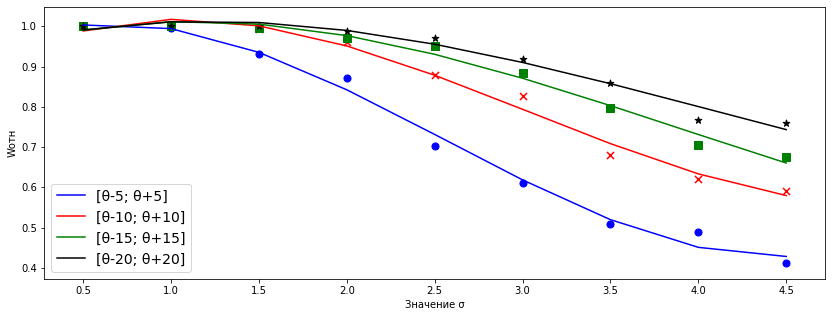

In [88]:
plt.figure(figsize=(14,5))
plt.ylabel('Wотн')
plt.xlabel('Значение σ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_W1, len(lst_sig), 3),
             color='blue',
             label='[θ-5; θ+5]')
plt.scatter(lst_sig, lst_W1, color='blue', s=50, marker='o')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_W2, len(lst_sig), 3),
             color='red',
             label='[θ-10; θ+10]')
plt.scatter(lst_sig, lst_W2, color='red', s=50, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_W3, len(lst_sig), 3),
             color='green',
             label='[θ-15; θ+15]')
plt.scatter(lst_sig, lst_W3, color='green', s=50, marker='s')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_W4, len(lst_sig), 3),
             color='black',
             label='[θ-20; θ+20]')
plt.scatter(lst_sig, lst_W4, color='black', s=50, marker='*')

plt.legend(fontsize=14) 
plt.show()

In [91]:
%%time
# Показатели W1, W2, W3, W4
lst_W1 = []
lst_W2 = []
lst_W3 = []
lst_W4 = []

for sig in lst_sig:
    # Для алгоритма BOR
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=len_timeseries,
            mean=1, 
            standard_deviation=sig,
            change_point_position=cpp,
            mean_change=2
        )

        result = algorithm_change_point_Q(seq=sequence)
        lst.append(result)
        
    W_1 = 0
    W_2 = 0
    W_3 = 0
    W_4 = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):       
        W_1 += calculate_W(k1, sample, CP=cpp)
        W_2 += calculate_W(k2, sample, CP=cpp)
        W_3 += calculate_W(k3, sample, CP=cpp)
        W_4 += calculate_W(k4, sample, CP=cpp)
        
    W_1 = W_1 / N_bootstrap
    W_2 = W_2 / N_bootstrap
    W_3 = W_3 / N_bootstrap
    W_4 = W_4 / N_bootstrap
    
    lst_W1.append(W_1)
    lst_W2.append(W_2)
    lst_W3.append(W_3)
    lst_W4.append(W_4)

C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in double_scalars


Wall time: 1h 3min 30s


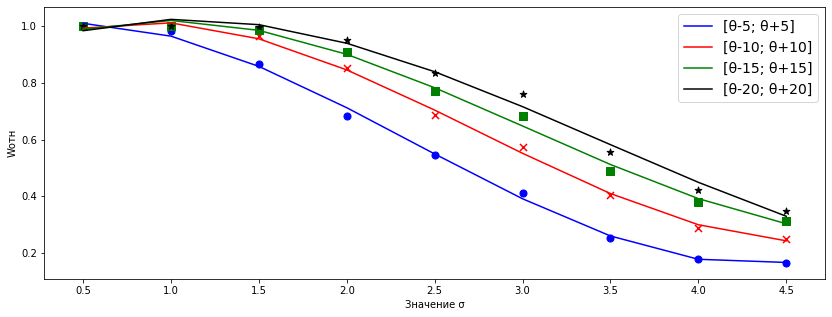

In [92]:
plt.figure(figsize=(14,5))
plt.ylabel('Wотн')
plt.xlabel('Значение σ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_W1, len(lst_sig), 3),
             color='blue',
             label='[θ-5; θ+5]')
plt.scatter(lst_sig, lst_W1, color='blue', s=50, marker='o')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_W2, len(lst_sig), 3),
             color='red',
             label='[θ-10; θ+10]')
plt.scatter(lst_sig, lst_W2, color='red', s=50, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_W3, len(lst_sig), 3),
             color='green',
             label='[θ-15; θ+15]')
plt.scatter(lst_sig, lst_W3, color='green', s=50, marker='s')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_W4, len(lst_sig), 3),
             color='black',
             label='[θ-20; θ+20]')
plt.scatter(lst_sig, lst_W4, color='black', s=50, marker='*')

plt.legend(fontsize=14) 
plt.show()

# Варьируем изменение скачка среднего (1) Wотн

In [93]:
# Показатели W1, W2, W3, W4
lst_W1 = []
lst_W2 = []
lst_W3 = []
lst_W4 = []

# Показатели K1, K2, K3, K4
k1 = 5
k2 = 10
k3 = 15
k4 = 20

# При различных значениях скачка
lst_delta = [a/100 for a in range(40, 201, 20)]
len_timeseries = 600
cpp = 300
N = 250
N_bootstrap = 10000

for delta in lst_delta:
    # Для алгоритма кусьюм
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=len_timeseries,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            mean_change=delta
        )

        result = algorithm_CUSUM_bootstrap(seq=sequence)
        lst.append(result)
        
    W_1 = 0
    W_2 = 0
    W_3 = 0
    W_4 = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):       
        W_1 += calculate_W(k1, sample, CP=cpp)
        W_2 += calculate_W(k2, sample, CP=cpp)
        W_3 += calculate_W(k3, sample, CP=cpp)
        W_4 += calculate_W(k4, sample, CP=cpp)
        
    W_1 = W_1 / N_bootstrap
    W_2 = W_2 / N_bootstrap
    W_3 = W_3 / N_bootstrap
    W_4 = W_4 / N_bootstrap
    
    lst_W1.append(W_1)
    lst_W2.append(W_2)
    lst_W3.append(W_3)
    lst_W4.append(W_4)

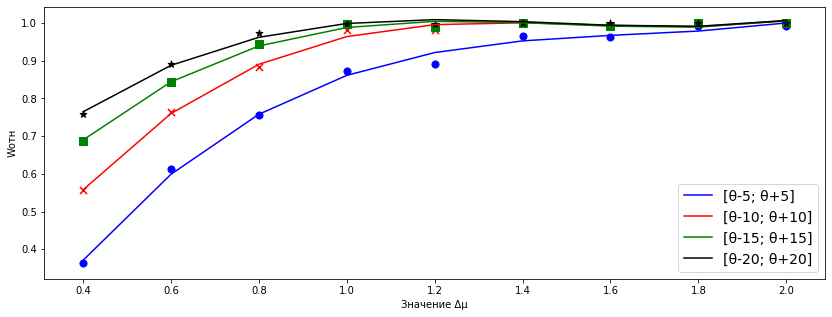

In [94]:
plt.figure(figsize=(14,5))
plt.ylabel('Wотн')
plt.xlabel('Значение Δμ')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W1, len(lst_delta), 3),
             color='blue',
             label='[θ-5; θ+5]')
plt.scatter(lst_delta, lst_W1, color='blue', s=50, marker='o')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W2, len(lst_delta), 3),
             color='red',
             label='[θ-10; θ+10]')
plt.scatter(lst_delta, lst_W2, color='red', s=50, marker='x')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W3, len(lst_delta), 3),
             color='green',
             label='[θ-15; θ+15]')
plt.scatter(lst_delta, lst_W3, color='green', s=50, marker='s')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W4, len(lst_delta), 3),
             color='black',
             label='[θ-20; θ+20]')
plt.scatter(lst_delta, lst_W4, color='black', s=50, marker='*')

plt.legend(fontsize=14) 
plt.show()

In [95]:
%%time
# Показатели W1, W2, W3, W4
lst_W1 = []
lst_W2 = []
lst_W3 = []
lst_W4 = []

for delta in lst_delta:
    # Для алгоритма FA
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=len_timeseries,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            mean_change=delta
        )

        result = algorithm_fa(seq=sequence)
        lst.append(result)
        
    W_1 = 0
    W_2 = 0
    W_3 = 0
    W_4 = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):       
        W_1 += calculate_W(k1, sample, CP=cpp)
        W_2 += calculate_W(k2, sample, CP=cpp)
        W_3 += calculate_W(k3, sample, CP=cpp)
        W_4 += calculate_W(k4, sample, CP=cpp)
        
    W_1 = W_1 / N_bootstrap
    W_2 = W_2 / N_bootstrap
    W_3 = W_3 / N_bootstrap
    W_4 = W_4 / N_bootstrap
    
    lst_W1.append(W_1)
    lst_W2.append(W_2)
    lst_W3.append(W_3)
    lst_W4.append(W_4)

Wall time: 6min 6s


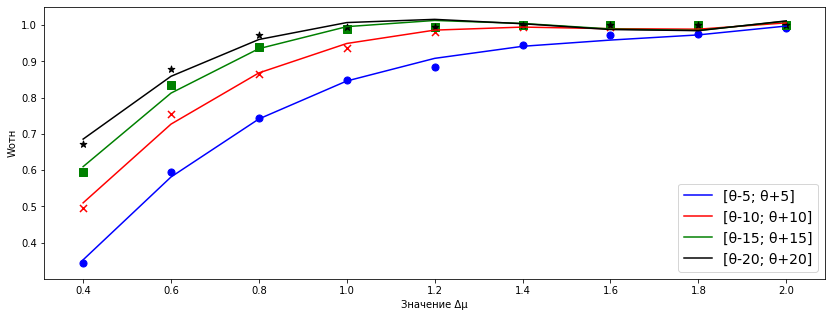

In [96]:
plt.figure(figsize=(14,5))
plt.ylabel('Wотн')
plt.xlabel('Значение Δμ')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W1, len(lst_delta), 3),
             color='blue',
             label='[θ-5; θ+5]')
plt.scatter(lst_delta, lst_W1, color='blue', s=50, marker='o')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W2, len(lst_delta), 3),
             color='red',
             label='[θ-10; θ+10]')
plt.scatter(lst_delta, lst_W2, color='red', s=50, marker='x')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W3, len(lst_delta), 3),
             color='green',
             label='[θ-15; θ+15]')
plt.scatter(lst_delta, lst_W3, color='green', s=50, marker='s')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W4, len(lst_delta), 3),
             color='black',
             label='[θ-20; θ+20]')
plt.scatter(lst_delta, lst_W4, color='black', s=50, marker='*')

plt.legend(fontsize=14) 
plt.show()

In [97]:
%%time
# Показатели W1, W2, W3, W4
lst_W1 = []
lst_W2 = []
lst_W3 = []
lst_W4 = []

for delta in lst_delta:
    # Для алгоритма FA
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=len_timeseries,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            mean_change=delta
        )

        result = algorithm_change_point_Q(seq=sequence)
        lst.append(result)
        
    W_1 = 0
    W_2 = 0
    W_3 = 0
    W_4 = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):       
        W_1 += calculate_W(k1, sample, CP=cpp)
        W_2 += calculate_W(k2, sample, CP=cpp)
        W_3 += calculate_W(k3, sample, CP=cpp)
        W_4 += calculate_W(k4, sample, CP=cpp)
        
    W_1 = W_1 / N_bootstrap
    W_2 = W_2 / N_bootstrap
    W_3 = W_3 / N_bootstrap
    W_4 = W_4 / N_bootstrap
    
    lst_W1.append(W_1)
    lst_W2.append(W_2)
    lst_W3.append(W_3)
    lst_W4.append(W_4)

C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in double_scalars


Wall time: 1h 4min 48s


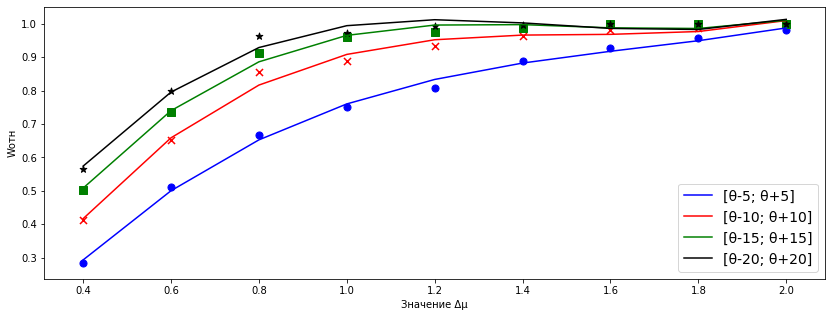

In [98]:
plt.figure(figsize=(14,5))
plt.ylabel('Wотн')
plt.xlabel('Значение Δμ')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W1, len(lst_delta), 3),
             color='blue',
             label='[θ-5; θ+5]')
plt.scatter(lst_delta, lst_W1, color='blue', s=50, marker='o')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W2, len(lst_delta), 3),
             color='red',
             label='[θ-10; θ+10]')
plt.scatter(lst_delta, lst_W2, color='red', s=50, marker='x')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W3, len(lst_delta), 3),
             color='green',
             label='[θ-15; θ+15]')
plt.scatter(lst_delta, lst_W3, color='green', s=50, marker='s')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W4, len(lst_delta), 3),
             color='black',
             label='[θ-20; θ+20]')
plt.scatter(lst_delta, lst_W4, color='black', s=50, marker='*')

plt.legend(fontsize=14) 
plt.show()

# Варьируем изменение среднеквадратичного (3) Wв

In [99]:
# Показатели W1, W2, W3, W4
lst_W1 = []
lst_W2 = []
lst_W3 = []
lst_W4 = []

# Показатели K1, K2, K3, K4
k1 = 5
k2 = 10
k3 = 15
k4 = 20

# При различных значениях скачка
lst_delta = [a/20 for a in range(20, 65, 5)]
len_timeseries = 600
cpp = 300
N = 250
N_bootstrap = 10000

for delta in lst_delta:
    # Для алгоритма FA
    lst = []
    for i in range(N):    
        sequence = ChagePointDispersion(
            N=len_timeseries,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            standard_deviation_change=delta
        )

        result = algorithm_fa(seq=sequence, type_cp='var')
        lst.append(result)
        
    W_1 = 0
    W_2 = 0
    W_3 = 0
    W_4 = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):       
        W_1 += calculate_W(k1, sample, CP=cpp)
        W_2 += calculate_W(k2, sample, CP=cpp)
        W_3 += calculate_W(k3, sample, CP=cpp)
        W_4 += calculate_W(k4, sample, CP=cpp)
        
    W_1 = W_1 / N_bootstrap
    W_2 = W_2 / N_bootstrap
    W_3 = W_3 / N_bootstrap
    W_4 = W_4 / N_bootstrap
    
    lst_W1.append(W_1)
    lst_W2.append(W_2)
    lst_W3.append(W_3)
    lst_W4.append(W_4)

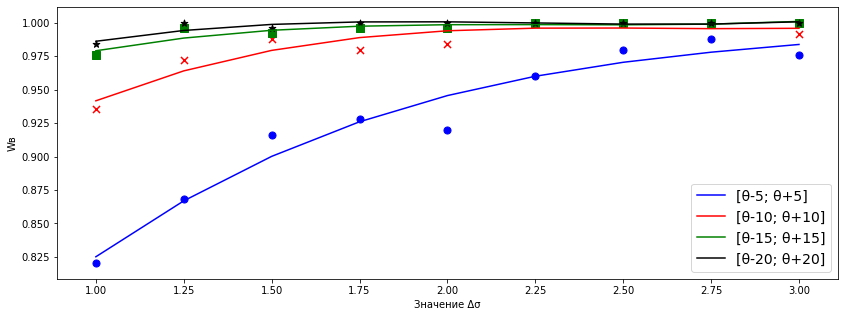

In [100]:
plt.figure(figsize=(14,5))
plt.ylabel('Wв')
plt.xlabel('Значение Δσ')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W1, len(lst_delta), 3),
             color='blue',
             label='[θ-5; θ+5]')
plt.scatter(lst_delta, lst_W1, color='blue', s=50, marker='o')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W2, len(lst_delta), 3),
             color='red',
             label='[θ-10; θ+10]')
plt.scatter(lst_delta, lst_W2, color='red', s=50, marker='x')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W3, len(lst_delta), 3),
             color='green',
             label='[θ-15; θ+15]')
plt.scatter(lst_delta, lst_W3, color='green', s=50, marker='s')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W4, len(lst_delta), 3),
             color='black',
             label='[θ-20; θ+20]')
plt.scatter(lst_delta, lst_W4, color='black', s=50, marker='*')

plt.legend(fontsize=14) 
plt.show()

In [101]:
# Показатели W1, W2, W3, W4
lst_W1 = []
lst_W2 = []
lst_W3 = []
lst_W4 = []

for delta in lst_delta:
    # Для алгоритма бор
    lst = []
    for i in range(N):    
        sequence = ChagePointDispersion(
            N=len_timeseries,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            standard_deviation_change=delta
        )

        result = algorithm_change_point_Q(seq=sequence)
        lst.append(result)
        
    W_1 = 0
    W_2 = 0
    W_3 = 0
    W_4 = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):       
        W_1 += calculate_W(k1, sample, CP=cpp)
        W_2 += calculate_W(k2, sample, CP=cpp)
        W_3 += calculate_W(k3, sample, CP=cpp)
        W_4 += calculate_W(k4, sample, CP=cpp)
        
    W_1 = W_1 / N_bootstrap
    W_2 = W_2 / N_bootstrap
    W_3 = W_3 / N_bootstrap
    W_4 = W_4 / N_bootstrap
    
    lst_W1.append(W_1)
    lst_W2.append(W_2)
    lst_W3.append(W_3)
    lst_W4.append(W_4)

C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in double_scalars


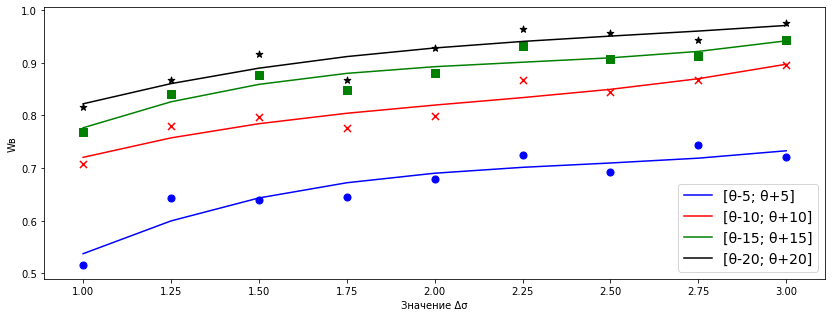

In [102]:
plt.figure(figsize=(14,5))
plt.ylabel('Wв')
plt.xlabel('Значение Δσ')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W1, len(lst_delta), 3),
             color='blue',
             label='[θ-5; θ+5]')
plt.scatter(lst_delta, lst_W1, color='blue', s=50, marker='o')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W2, len(lst_delta), 3),
             color='red',
             label='[θ-10; θ+10]')
plt.scatter(lst_delta, lst_W2, color='red', s=50, marker='x')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W3, len(lst_delta), 3),
             color='green',
             label='[θ-15; θ+15]')
plt.scatter(lst_delta, lst_W3, color='green', s=50, marker='s')

sns.lineplot(x=lst_delta, 
             y=savgol_filter(lst_W4, len(lst_delta), 3),
             color='black',
             label='[θ-20; θ+20]')
plt.scatter(lst_delta, lst_W4, color='black', s=50, marker='*')

plt.legend(fontsize=14) 
plt.show()

# Плотности для ретроспективных алгоритмов

In [116]:
%%time
N = 1000
lst_mean_1 = []
for i in range(N):    
    sequence = ChagePointMean(
        N=600,
        mean=1, 
        standard_deviation=3, 
        change_point_position=300, 
        mean_change=1)

    result = algorithm_CUSUM_bootstrap(seq=sequence)
    lst_mean_1.append(result)

lst_mean_2 = []
for i in range(N):    
    sequence = ChagePointMean(
        N=600,
        mean=1, 
        standard_deviation=3, 
        change_point_position=300, 
        mean_change=1)

    result = algorithm_fa(seq=sequence)
    lst_mean_2.append(result)
    
lst_mean_3 = []
for i in range(N):    
    sequence = ChagePointMean(
        N=600,
        mean=1, 
        standard_deviation=3, 
        change_point_position=300, 
        mean_change=1)

    result = algorithm_change_point_Q(seq=sequence)
    lst_mean_3.append(result)

C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in double_scalars


Wall time: 39min 1s


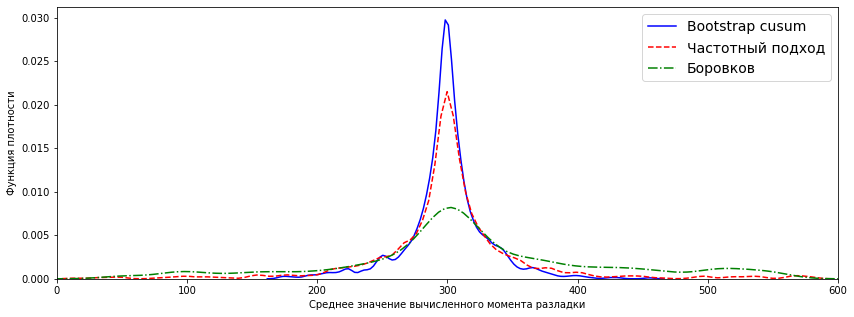

In [132]:
plt.figure(figsize=(14,5))
plt.ylabel('Функция плотности')
plt.xlabel('Среднее значение вычисленного момента разладки')

plt.xlim(0, 600)

sns.kdeplot(lst_mean_1, 
            clip=(0, 600.0),
            kernel='gau',
            bw='silverman',
            color='blue',
            label='Bootstrap cusum');

sns.kdeplot(lst_mean_2, 
            clip=(10, 590.0),
            kernel='gau',
            bw='silverman',
            color='red',
            linestyle='--',
            label='Частотный подход');

sns.kdeplot(lst_mean_3, 
            clip=(40, 560.0),
            kernel='gau',
            bw='silverman',
            color='green',
            linestyle='-.',
            label='Боровков');

plt.legend(fontsize=14) 
plt.show()

In [139]:
%%time
N = 1000
lst_mean_1 = []
for i in range(N):    
    sequence = ChagePointDispersion(
        N=600,
        mean=1, 
        standard_deviation=1, 
        change_point_position=300, 
        standard_deviation_change=1)

    result = algorithm_CUSUM_bootstrap(seq=sequence)
    lst_mean_1.append(result)

lst_mean_2 = []
for i in range(N):    
    sequence = ChagePointDispersion(
        N=600,
        mean=1, 
        standard_deviation=1, 
        change_point_position=300, 
        standard_deviation_change=1)

    result = algorithm_fa(seq=sequence, type_cp='var')
    lst_mean_2.append(result)
    
lst_mean_3 = []
for i in range(N):    
    sequence = ChagePointDispersion(
        N=600,
        mean=1, 
        standard_deviation=1, 
        change_point_position=300, 
        standard_deviation_change=1)

    result = algorithm_change_point_Q(seq=sequence)
    lst_mean_3.append(result)

C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in double_scalars


Wall time: 37min 8s


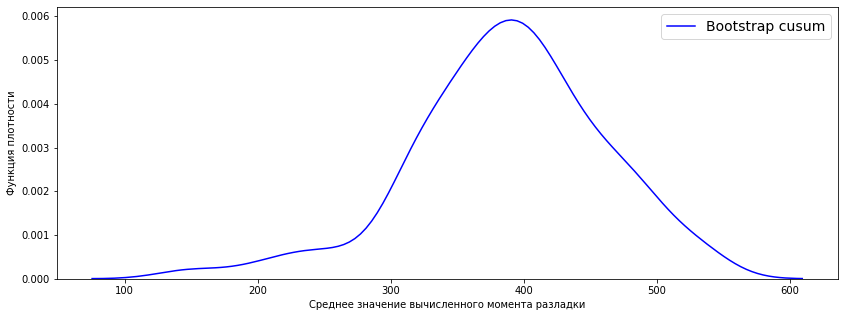

In [146]:
plt.figure(figsize=(14,5))
plt.ylabel('Функция плотности')
plt.xlabel('Среднее значение вычисленного момента разладки')

# plt.xlim(400, 420)

sns.kdeplot(lst_mean_1, 
            clip=(0, 600.0),
            kernel='gau',
            bw='silverman',
            color='blue',
            label='Bootstrap cusum');

# sns.kdeplot(lst_mean_2, 
#             clip=(0, 600.0),
#             kernel='gau',
#             bw='silverman',
#             color='red',
#             linestyle='--',
#             label='Частотный подход');

# sns.kdeplot(lst_mean_3, 
#             clip=(0, 590.0),
#             kernel='gau',
#             bw='silverman',
#             color='green',
#             linestyle='-.',
#             label='Боровков');

plt.legend(fontsize=14) 
plt.show()

# Варьируем коэф. а (2) upd

In [66]:
%%time
# Показатели среднего времени запаздывания
lst_cb_t = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_cb_sigma = []
# При различных значениях а
lst_a = [a/20 for a in range(10, 61, 5)]
len_timeseries = 600
cpp = 300
N = 250
N_bootstrap = 10000

for a in lst_a:
    # Для алгоритма кусьюм
    lst = []
    for i in range(N):    
        sequence = ChagePointMeanDynamic(
            N=len_timeseries,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            mean_change=a
        )

        result = algorithm_CUSUM_bootstrap(seq=sequence)
        lst.append(result)
    
    # Считаем среднее с помощью бутстрэпа
    average_lag_time = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap): 
        average_lag_time += np.mean(sample)
        std_time += np.std(sample)
        
    average_lag_time = average_lag_time / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_cb_t.append(average_lag_time)
    lst_cb_sigma.append(std_time)

Wall time: 10min 38s


In [75]:
%%time
# Показатели среднего времени запаздывания
lst_fa_t = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_fa_sigma = []

for a in lst_a:    
    # Для частотного подхода
    lst = []
    for i in range(N):    
        sequence = ChagePointMeanDynamic(
            N=len_timeseries,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            mean_change=a
        )

        result = algorithm_fa(seq=sequence)
        lst.append(result)
        
    # Считаем среднее с помощью бутстрэпа
    average_lag_time = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):
        average_lag_time += np.mean(sample)
        std_time += np.std(sample)
        
    average_lag_time = average_lag_time / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_fa_t.append(average_lag_time)
    lst_fa_sigma.append(std_time)

Wall time: 2min 42s


In [68]:
%%time
# Показатели среднего времени запаздывания
lst_bor_t = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_bor_sigma = []

for a in lst_a:    
    # Для Боровкова
    lst = []
    for i in range(N):    
        sequence = ChagePointMeanDynamic(
            N=len_timeseries,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            mean_change=a
        )

        result = algorithm_change_point_Q(seq=sequence)
        lst.append(result)
        
    # Считаем среднее с помощью бутстрэпа
    average_lag_time = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):
        average_lag_time += np.mean(sample)
        std_time += np.std(sample)
        
    average_lag_time = average_lag_time / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_bor_t.append(average_lag_time)
    lst_bor_sigma.append(std_time)

C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in double_scalars


Wall time: 31min 47s


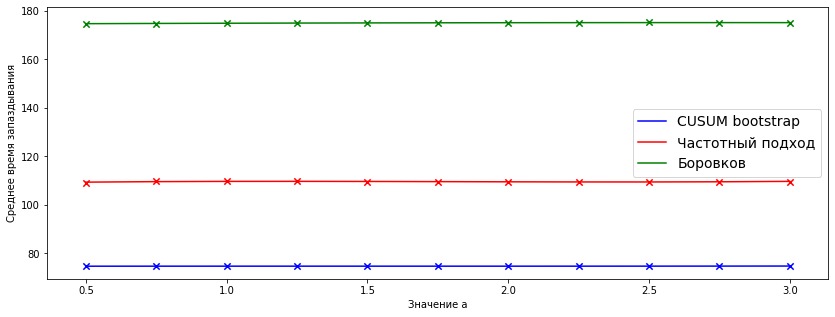

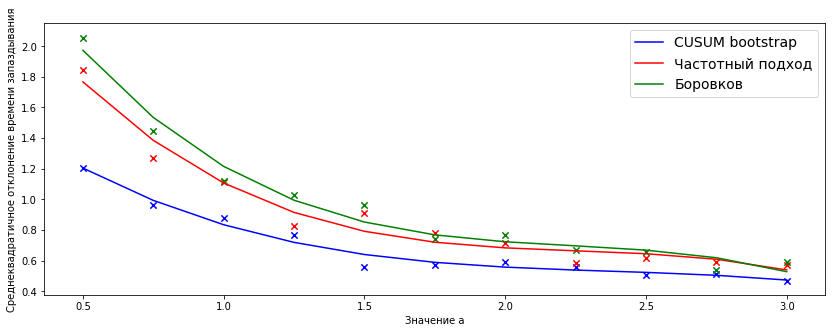

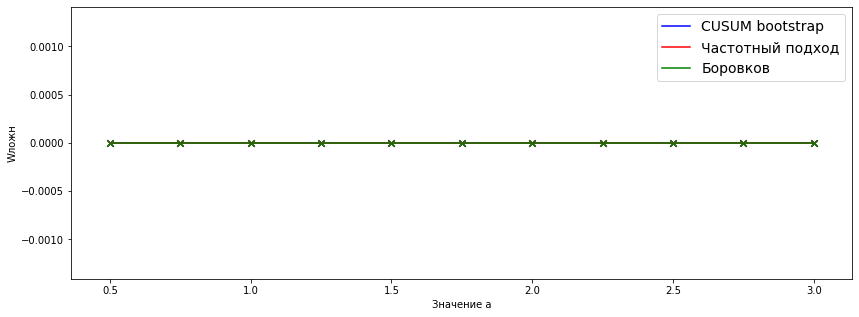

In [69]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднее значение вычисленного момента разладки')
plt.xlabel('Значение а')

sns.lineplot(x=lst_a, 
             y=savgol_filter(lst_cb_t, len(lst_a), 3),
             color='blue',
             label='CUSUM bootstrap')
plt.scatter(lst_a, lst_cb_t, color='blue', s=40, marker='x')

sns.lineplot(x=lst_a, 
             y=savgol_filter(lst_fa_t, len(lst_a), 3),
             color='red',
             linestyle='--',
             label='Частотный подход')
plt.scatter(lst_a, lst_fa_t, color='red', s=40, marker='x')

sns.lineplot(x=lst_a, 
             y=savgol_filter(lst_bor_t, len(lst_a), 3),
             color='green',
             linestyle='-.',
             label='Боровков')
plt.scatter(lst_a, lst_bor_t, color='green', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение вычисленного момента разладки')
plt.xlabel('Значение а')

sns.lineplot(x=lst_a, 
             y=savgol_filter(lst_cb_sigma, len(lst_a), 3),
             color='blue',
             label='CUSUM bootstrap')
plt.scatter(lst_a, lst_cb_sigma, color='blue', s=40, marker='x')

sns.lineplot(x=lst_a, 
             y=savgol_filter(lst_fa_sigma, len(lst_a), 3),
             color='red',
             linestyle='--',
             label='Частотный подход')
plt.scatter(lst_a, lst_fa_sigma, color='red', s=40, marker='x')

sns.lineplot(x=lst_a, 
             y=savgol_filter(lst_bor_sigma, len(lst_a), 3),
             color='green',
             linestyle='-.',
             label='Боровков')
plt.scatter(lst_a, lst_bor_sigma, color='green', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()


In [70]:
print('Среднее время запаздывания')
for i in range(len(lst_a)):
    print('При а =', lst_a[i])
    print('CB = ', lst_cb_t[i], 'FA = ', lst_fa_t[i], 'BOR = ', lst_bor_t[i])

print('---------------------------------------------------------------------------------------------')
    
print('Среднеквадратичное отклонение времени запаздывания')
for i in range(len(lst_a)):
    print('При а =', lst_a[i])
    print('CB = ', lst_cb_sigma[i], 'FA = ', lst_fa_sigma[i], 'BOR = ', lst_bor_sigma[i])
    
print('---------------------------------------------------------------------------------------------')
    

Среднее время запаздывания
При а = 0.5
CB =  74.55999999999895 FA =  109.13000000000117 BOR =  174.72000000000102
При а = 0.75
CB =  74.69999999999858 FA =  109.74000000000171 BOR =  174.6900000000018
При а = 1.0
CB =  74.53999999999989 FA =  109.6600000000024 BOR =  174.95000000000138
При а = 1.25
CB =  74.69999999999858 FA =  109.5899999999976 BOR =  174.8900000000031
При а = 1.5
CB =  74.5 FA =  109.41999999999852 BOR =  174.97000000000102
При а = 1.75
CB =  74.6600000000019 FA =  109.44000000000146 BOR =  175.14999999999674
При а = 2.0
CB =  74.5700000000006 FA =  109.44999999999813 BOR =  175.02999999999898
При а = 2.25
CB =  74.6399999999995 FA =  109.39999999999829 BOR =  175.10000000000326
При а = 2.5
CB =  74.67999999999937 FA =  109.4100000000024 BOR =  175.17999999999572
При а = 2.75
CB =  74.58000000000133 FA =  109.5099999999983 BOR =  175.0499999999986
При а = 3.0
CB =  74.67999999999937 FA =  109.52999999999905 BOR =  175.14999999999674
----------------------------------

# Варьируем среднеквадратичное (2) upd

In [78]:
%%time
# Показатели среднего времени запаздывания
lst_cb_t = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_cb_sigma = []
# При различных значениях сигма
lst_sig = [a/20 for a in range(10, 61, 5)]
len_timeseries = 600
cpp = 300
N = 250
N_bootstrap = 10000

for sig in lst_sig:
    # Для алгоритма кусьюм
    lst = []
    for i in range(N):    
        sequence = ChagePointMeanDynamic(
            N=len_timeseries,
            mean=1, 
            standard_deviation=sig,
            change_point_position=cpp,
            mean_change=0.5
        )

        result = algorithm_CUSUM_bootstrap(seq=sequence)
        lst.append(result)
        
    # Считаем среднее с помощью бутстрэпа
    average_lag_time = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):       
        average_lag_time += np.mean(sample)
        std_time += np.std(sample)
        
    average_lag_time = average_lag_time / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_cb_t.append(average_lag_time)
    lst_cb_sigma.append(std_time)

KeyboardInterrupt: 

In [79]:
%%time
# Показатели среднего времени запаздывания
lst_fa_t = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_fa_sigma = []

for sig in lst_sig: 
    # Для FA
    lst = []
    for i in range(N):    
        sequence = ChagePointMeanDynamic(
            N=len_timeseries,
            mean=1, 
            standard_deviation=sig,
            change_point_position=cpp,
            mean_change=0.5
        )

        result = algorithm_fa(seq=sequence)
        lst.append(result)
        
    # Считаем среднее с помощью бутстрэпа
    average_lag_time = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):       
        average_lag_time += np.mean(sample)
        std_time += np.std(sample)
        
    average_lag_time = average_lag_time / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_fa_t.append(average_lag_time)
    lst_fa_sigma.append(std_time)

KeyboardInterrupt: 

In [80]:
%%time
# Показатели среднего времени запаздывания
lst_bor_t = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_bor_sigma = []

for sig in lst_sig: 
    # Для Боровкова
    lst = []
    for i in range(N):    
        sequence = ChagePointMeanDynamic(
            N=len_timeseries,
            mean=1, 
            standard_deviation=sig,
            change_point_position=cpp,
            mean_change=0.5
        )

        result = algorithm_change_point_Q(seq=sequence)
        lst.append(result)
        
    # Считаем среднее с помощью бутстрэпа
    average_lag_time = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):       
        average_lag_time += np.mean(sample)
        std_time += np.std(sample)
        
    average_lag_time = average_lag_time / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_bor_t.append(average_lag_time)
    lst_bor_sigma.append(std_time)

C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in double_scalars


KeyboardInterrupt: 

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

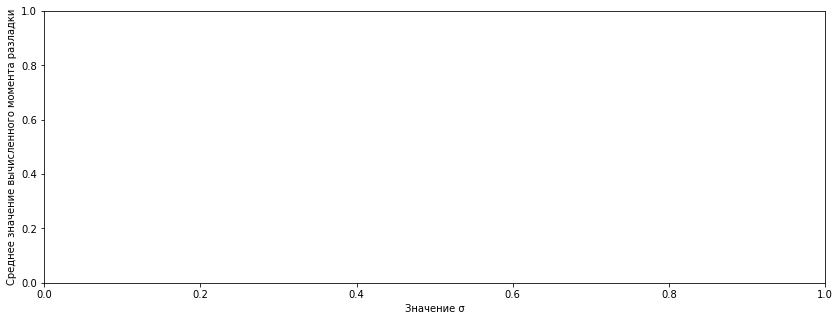

In [81]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднее значение вычисленного момента разладки')
plt.xlabel('Значение σ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_cb_t, len(lst_sig), 3),
             color='blue',
             label='CUSUM bootstrap')
plt.scatter(lst_sig, lst_cb_t, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_fa_t, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Частотный подход')
plt.scatter(lst_sig, lst_fa_t, color='red', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_bor_t, len(lst_sig), 3),
             color='green',
             linestyle='--',
             label='Боровков')
plt.scatter(lst_sig, lst_bor_t, color='green', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение вычисленного момента разладки')
plt.xlabel('Значение σ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_cb_sigma, len(lst_sig), 3),
             color='blue',
             label='CUSUM bootstrap')
plt.scatter(lst_sig, lst_cb_sigma, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_fa_sigma, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Частотный подход')
plt.scatter(lst_sig, lst_fa_sigma, color='red', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_bor_sigma, len(lst_sig), 3),
             color='green',
             linestyle='--',
             label='Боровков')
plt.scatter(lst_sig, lst_bor_sigma, color='green', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

In [ ]:
print('Среднее время запаздывания')
for i in range(len(lst_sig)):
    print('При σ =', lst_sig[i])
    print('CB = ', lst_cb_t[i], 'FA = ', lst_fa_t[i], 'BOR = ', lst_bor_t[i])

print('---------------------------------------------------------------------------------------------')
    
print('Среднеквадратичное отклонение времени запаздывания')
for i in range(len(lst_sig)):
    print('При σ =', lst_sig[i])
    print('CB = ', lst_cb_sigma[i], 'FA = ', lst_fa_sigma[i], 'BOR = ', lst_bor_sigma[i])
    
print('---------------------------------------------------------------------------------------------')

# Варьируем среднеквадратичное (1) upd

In [ ]:
%%time
# Показатели среднего времени запаздывания
lst_cb_t = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_cb_sigma = []
# При различных значениях сигма
lst_sig = [a/20 for a in range(10, 61, 5)]
len_timeseries = 600
cpp = 300
N = 250
N_bootstrap = 10000

for sig in lst_sig:
    # Для алгоритма кусьюм
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=len_timeseries,
            mean=1, 
            standard_deviation=sig,
            change_point_position=cpp,
            mean_change=2
        )

        result = algorithm_CUSUM_bootstrap(seq=sequence)
        lst.append(result)
        
    # Считаем среднее с помощью бутстрэпа
    average_lag_time = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):       
        average_lag_time += np.mean(sample)
        std_time += np.std(sample)
        
    average_lag_time = average_lag_time / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_cb_t.append(average_lag_time)
    lst_cb_w.append(false_detection_probability)
    lst_cb_sigma.append(std_time)

In [ ]:
%%time
# Показатели среднего времени запаздывания
lst_fa_t = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_fa_sigma = []

for sig in lst_sig: 
    # Для FA
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=len_timeseries,
            mean=1, 
            standard_deviation=sig,
            change_point_position=cpp,
            mean_change=2
        )

        result = algorithm_fa(seq=sequence)
        lst.append(result)
        
    # Считаем среднее с помощью бутстрэпа
    average_lag_time = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):       
        average_lag_time += np.mean(sample)
        std_time += np.std(sample)
        
    average_lag_time = average_lag_time / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_fa_t.append(average_lag_time)
    lst_fa_w.append(false_detection_probability)
    lst_fa_sigma.append(std_time)

In [ ]:
%%time
# Показатели среднего времени запаздывания
lst_bor_t = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_bor_sigma = []

for sig in lst_sig: 
    # Для Боровкова
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=len_timeseries,
            mean=1, 
            standard_deviation=sig,
            change_point_position=cpp,
            mean_change=2
        )

        result = algorithm_change_point_Q(seq=sequence)
        lst.append(result)
        
    # Считаем среднее с помощью бутстрэпа
    average_lag_time = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):       
        average_lag_time += np.mean(sample)
        std_time += np.std(sample)
        
    average_lag_time = average_lag_time / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_bor_t.append(average_lag_time)
    lst_bor_w.append(false_detection_probability)
    lst_bor_sigma.append(std_time)

In [ ]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднее значение вычисленного момента разладки')
plt.xlabel('Значение σ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_cb_t, len(lst_sig), 3),
             color='blue',
             label='CUSUM bootstrap')
plt.scatter(lst_sig, lst_cb_t, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_fa_t, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Частотный подход')
plt.scatter(lst_sig, lst_fa_t, color='red', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_bor_t, len(lst_sig), 3),
             color='green',
             linestyle='--',
             label='Боровков')
plt.scatter(lst_sig, lst_bor_t, color='green', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение вычисленного момента разладки')
plt.xlabel('Значение σ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_cb_sigma, len(lst_sig), 3),
             color='blue',
             label='CUSUM bootstrap')
plt.scatter(lst_sig, lst_cb_sigma, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_fa_sigma, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Частотный подход')
plt.scatter(lst_sig, lst_fa_sigma, color='red', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_bor_sigma, len(lst_sig), 3),
             color='green',
             linestyle='--',
             label='Боровков')
plt.scatter(lst_sig, lst_bor_sigma, color='green', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

In [ ]:
print('Среднее время запаздывания')
for i in range(len(lst_sig)):
    print('При σ =', lst_a[i])
    print('CB = ', lst_cb_t[i], 'FA = ', lst_fa_t[i], 'BOR = ', lst_bor_t[i])

print('---------------------------------------------------------------------------------------------')
    
print('Среднеквадратичное отклонение времени запаздывания')
for i in range(len(lst_sig)):
    print('При σ =', lst_a[i])
    print('CB = ', lst_cb_sigma[i], 'FA = ', lst_fa_sigma[i], 'BOR = ', lst_bor_sigma[i])
    
print('---------------------------------------------------------------------------------------------')

# Варьируем изменение скачка среднего (1)

In [ ]:
lst_sig = [a/20 for a in range(10, 71, 5)]

In [62]:
%%time
# Показатели среднего времени запаздывания
lst_cb_t = []
# Показатели относительной частоты ложного обнаружения
lst_cb_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_cb_sigma = []
# При различных значениях сигма
lst_sig = [a/20 for a in range(10, 71, 5)]
len_timeseries = 600
cpp = 300
N = 100
N_bootstrap = 1000

for sig in lst_sig:
    # Для алгоритма кусьюм
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=len_timeseries,
            mean=1, 
            standard_deviation=sig,
            change_point_position=cpp,
            mean_change=2
        )

        result = algorithm_CUSUM_bootstrap(seq=sequence)
        lst.append(result)
        
    # Считаем среднее с помощью бутстрэпа
    average_lag_time = 0
    # Считаем относительную частоту ложного обнаружения с помощью бутстрэпа
    false_detection_probability = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap):
        
        lst_mean = [x-cpp for x in lst if x >= cpp]
        lst_freq = [x for x in lst if 0 < x < cpp]
        
        average_lag_time += np.mean(lst_mean)
        false_detection_probability += len(lst_freq)/N
        std_time += np.std(lst_mean)
        
    average_lag_time = average_lag_time / N_bootstrap
    false_detection_probability = false_detection_probability / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_cb_t.append(average_lag_time)
    lst_cb_w.append(false_detection_probability)
    lst_cb_sigma.append(std_time)

Wall time: 13min 6s


In [63]:
%%time
# Показатели среднего времени запаздывания
lst_vrb_t = []
# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_vrb_sigma = []

for sig in lst_sig: 
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=1000,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            mean_change=sig
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=10)
        lst.append(result)
        
    lst_mean = [x-cpp for x in lst if x >= cpp]
    lst_freq = [x for x in lst if 0 < x < cpp]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_vrb_t.append(average_lag_time)
    lst_vrb_w.append(false_detection_probability)
    lst_vrb_sigma.append(std_time)

Wall time: 13min 3s


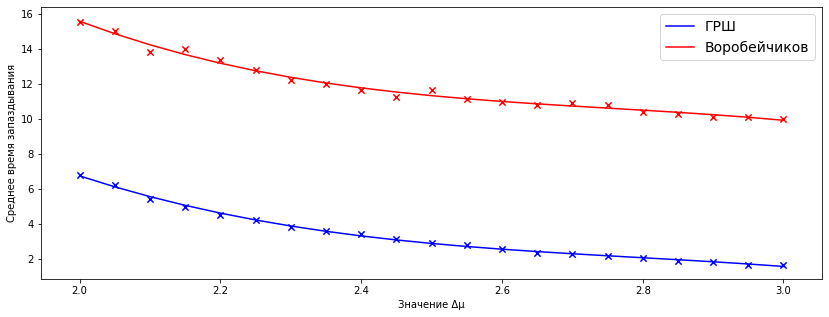

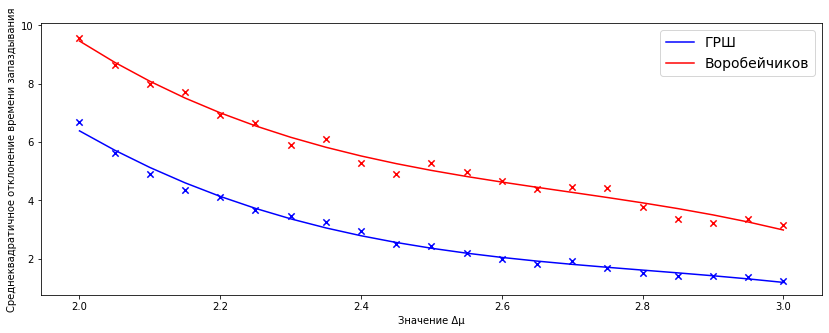

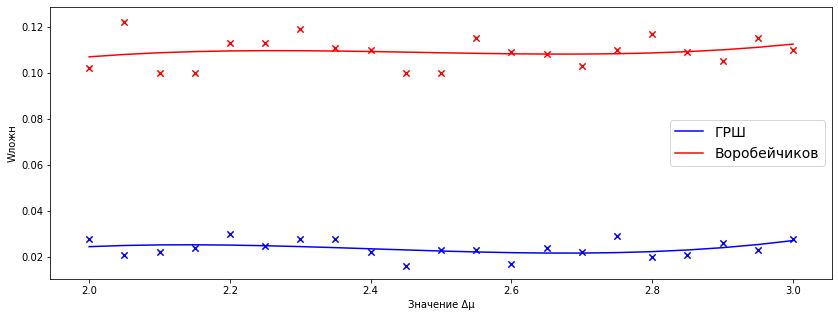

In [64]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднее время запаздывания')
plt.xlabel('Значение Δμ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_t, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_t, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_t, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_t, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение времени запаздывания')
plt.xlabel('Значение Δμ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_sigma, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_sigma, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_sigma, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_sigma, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение Δμ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_w, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_w, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_w, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

# Варьируем изменение среднеквадратичного (3)

In [65]:
%%time
# Показатели среднего времени запаздывания
lst_grsh_t = []
# Показатели относительной частоты ложного обнаружения
lst_grsh_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_grsh_sigma = []
# При различных значениях сигма
lst_sig = [a/20 for a in range(20, 65, 5)]
cpp = 600
N = 1000

for sig in lst_sig:
    # Для ГРШ
    lst = []
    for i in range(N):    
        sequence = ChagePointDispersion(
            N=1000,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            standard_deviation_change=sig
        )

        result = algorithm_grsh(seq=sequence, g=12, k=100)
        lst.append(result)
        
    lst_mean = [x-cpp for x in lst if x >= cpp]
    lst_freq = [x for x in lst if 0 < x < cpp]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_grsh_t.append(average_lag_time)
    lst_grsh_w.append(false_detection_probability)
    lst_grsh_sigma.append(std_time)

Wall time: 5min 52s


In [66]:
%%time
# Показатели среднего времени запаздывания
lst_vrb_t = []
# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_vrb_sigma = []

for sig in lst_sig: 
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointDispersion(
            N=1000,
            mean=1, 
            standard_deviation=1,
            change_point_position=cpp,
            standard_deviation_change=sig
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=10)
        lst.append(result)
        
    lst_mean = [x-cpp for x in lst if x >= cpp]
    lst_freq = [x for x in lst if 0 < x < cpp]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_vrb_t.append(average_lag_time)
    lst_vrb_w.append(false_detection_probability)
    lst_vrb_sigma.append(std_time)

Wall time: 9min 9s


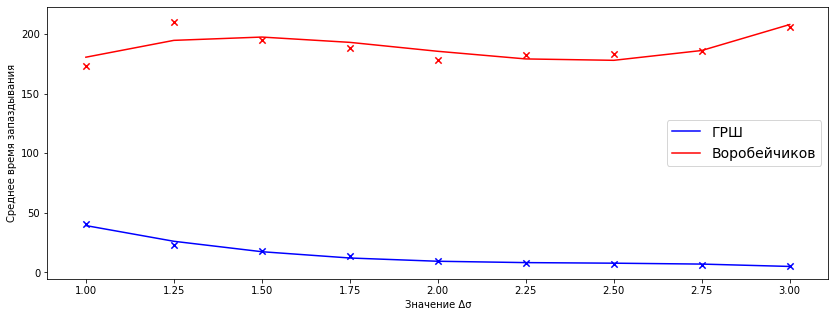

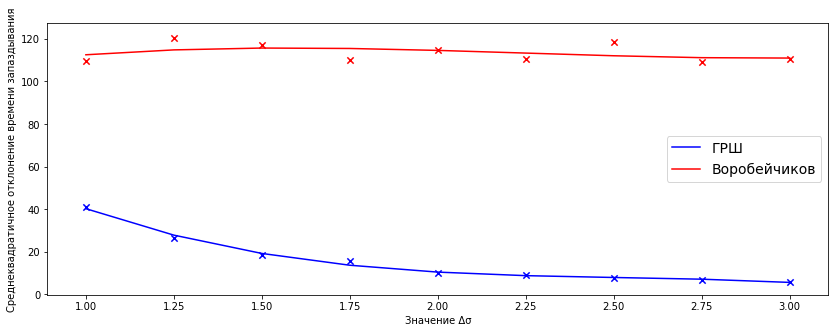

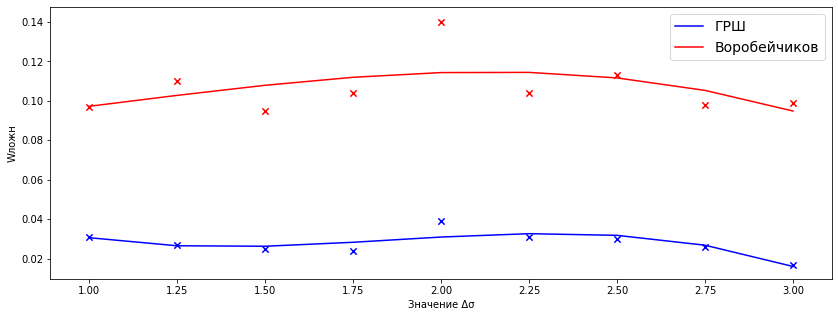

In [67]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднее время запаздывания')
plt.xlabel('Значение Δσ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_t, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_t, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_t, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_t, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение времени запаздывания')
plt.xlabel('Значение Δσ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_sigma, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_sigma, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_sigma, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_sigma, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение Δσ')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_grsh_w, len(lst_sig), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_sig, lst_grsh_w, color='blue', s=40, marker='x')

sns.lineplot(x=lst_sig, 
             y=savgol_filter(lst_vrb_w, len(lst_sig), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_sig, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

# Варьируем позицию момента разладки (1)

In [118]:
%%time
# Показатели среднего времени запаздывания
lst_grsh_t = []
# Показатели относительной частоты ложного обнаружения
lst_grsh_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_grsh_sigma = []
# При различных значениях позиции
lst_theta = [a for a in range(200, 950, 50)]
N = 1000

for theta in lst_theta:
    # Для ГРШ
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=1000,
            mean=1, 
            standard_deviation=1,
            change_point_position=theta,
            mean_change=2
        )

        result = algorithm_grsh(seq=sequence, g=12, k=100)
        lst.append(result)
        
    lst_mean = [x-theta for x in lst if x >= theta]
    lst_freq = [x for x in lst if 0 < x < theta]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_grsh_t.append(average_lag_time)
    lst_grsh_w.append(false_detection_probability)
    lst_grsh_sigma.append(std_time)

Wall time: 8min 40s


In [119]:
%%time
# Показатели среднего времени запаздывания
lst_vrb_t = []
# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_vrb_sigma = []

for theta in lst_theta: 
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=1000,
            mean=1, 
            standard_deviation=1,
            change_point_position=theta,
            mean_change=2
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=12, t0=100)
        lst.append(result)
        
    lst_mean = [x-theta for x in lst if x >= theta]
    lst_freq = [x for x in lst if 0 < x < theta]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_vrb_t.append(average_lag_time)
    lst_vrb_w.append(false_detection_probability)
    lst_vrb_sigma.append(std_time)

Wall time: 9min


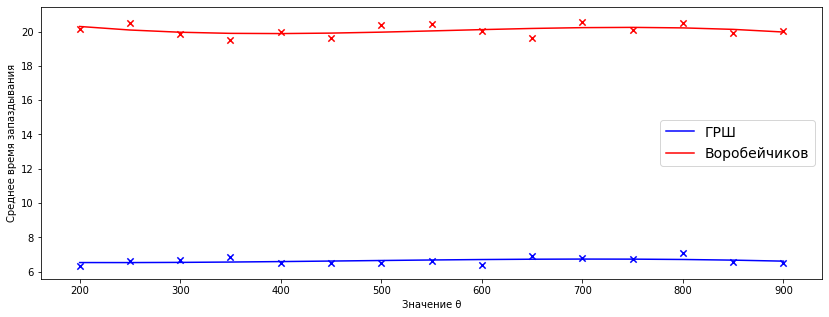

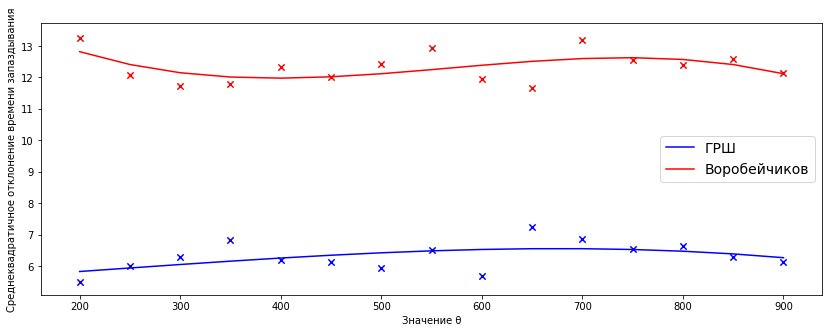

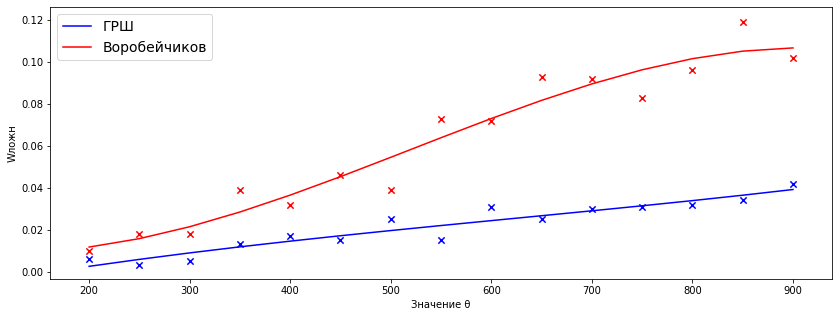

In [120]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднее время запаздывания')
plt.xlabel('Значение θ')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_grsh_t, len(lst_theta), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_theta, lst_grsh_t, color='blue', s=40, marker='x')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_vrb_t, len(lst_theta), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_theta, lst_vrb_t, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение времени запаздывания')
plt.xlabel('Значение θ')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_grsh_sigma, len(lst_theta), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_theta, lst_grsh_sigma, color='blue', s=40, marker='x')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_vrb_sigma, len(lst_theta), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_theta, lst_vrb_sigma, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение θ')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_grsh_w, len(lst_theta), 3),
             color='blue',
             label='ГРШ')
plt.scatter(lst_theta, lst_grsh_w, color='blue', s=40, marker='x')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_vrb_w, len(lst_theta), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_theta, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

# Черновик

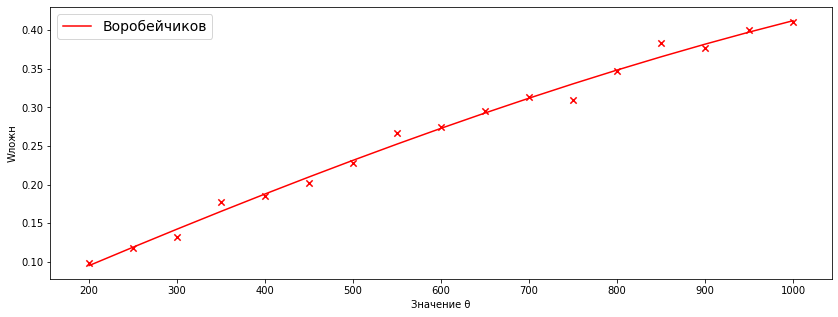

Wall time: 9min 57s


In [116]:
%%time

# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []

# При различных значениях позиции
lst_theta = [a for a in range(200, 1050, 50)]
N = 1000

for theta in lst_theta: 
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=1200,
            mean=1, 
            standard_deviation=1,
            change_point_position=theta,
            mean_change=2
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=10, t0=theta//10)
        lst.append(result)
        
    lst_freq = [x for x in lst if 0 < x < theta]
    false_detection_probability = len(lst_freq)/N
    lst_vrb_w.append(false_detection_probability)
    
    
plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение θ')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_vrb_w, len(lst_theta), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_theta, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

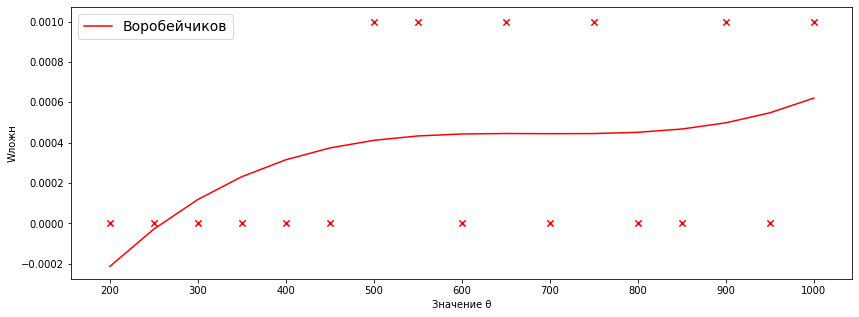

Wall time: 13min 13s


In [117]:
%%time

# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []

# При различных значениях позиции
lst_theta = [a for a in range(200, 1050, 50)]
N = 1000

for theta in lst_theta: 
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=1200,
            mean=1, 
            standard_deviation=1,
            change_point_position=theta,
            mean_change=2
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=20, t0=100)
        lst.append(result)
        
    lst_freq = [x for x in lst if 0 < x < theta]
    false_detection_probability = len(lst_freq)/N
    lst_vrb_w.append(false_detection_probability)
    
    
plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение θ')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_vrb_w, len(lst_theta), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_theta, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

# Варьируем t0 для алгоритма Воробейчикова

In [110]:
%%time
# Показатели среднего времени запаздывания
lst_vrb_t = []
# Показатели относительной частоты ложного обнаружения
lst_vrb_w = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_vrb_sigma = []

lst_t0 = [a for a in range(50, 601, 25)]
N = 1000
theta=700

for t0 in lst_t0: 
    # Для Воробейчикова
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=1000,
            mean=1, 
            standard_deviation=1,
            change_point_position=theta,
            mean_change=2
        )

        result, _ = algorithm_change_point_St(seq=sequence, difference_step_count=10, t0=t0)
        lst.append(result)
        
    lst_mean = [x-theta for x in lst if x >= theta]
    lst_freq = [x for x in lst if 0 < x < theta]

    average_lag_time = np.mean(lst_mean)
    false_detection_probability = len(lst_freq)/N
    std_time = np.std(lst_mean)
    
    lst_vrb_t.append(average_lag_time)
    lst_vrb_w.append(false_detection_probability)
    lst_vrb_sigma.append(std_time)

Wall time: 16min 16s


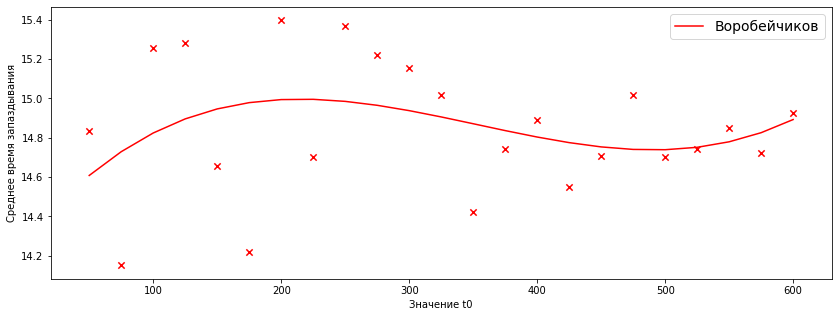

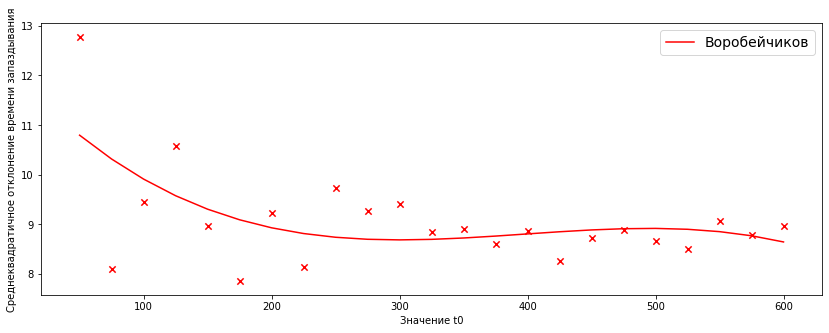

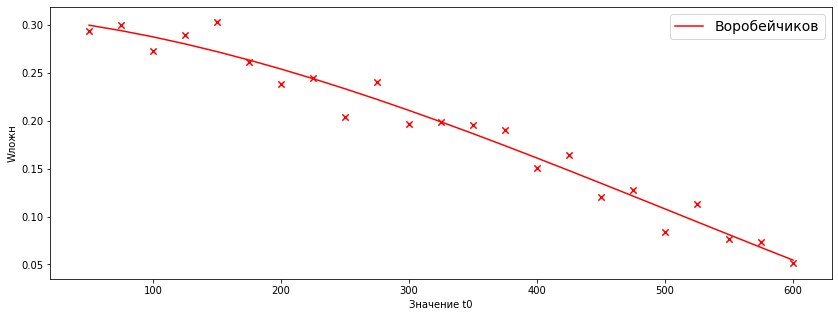

In [111]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднее время запаздывания')
plt.xlabel('Значение t0')

sns.lineplot(x=lst_t0, 
             y=savgol_filter(lst_vrb_t, len(lst_t0), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_t0, lst_vrb_t, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение времени запаздывания')
plt.xlabel('Значение t0')

sns.lineplot(x=lst_t0, 
             y=savgol_filter(lst_vrb_sigma, len(lst_t0), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_t0, lst_vrb_sigma, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Wложн')
plt.xlabel('Значение t0')

sns.lineplot(x=lst_t0, 
             y=savgol_filter(lst_vrb_w, len(lst_t0), 3),
             color='red',
             linestyle='--',
             label='Воробейчиков')
plt.scatter(lst_t0, lst_vrb_w, color='red', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

# Поведение алгоритмов в зависимости от объема выборки (м1)

In [15]:
def calculate_W(k, change_point_list, CP=600):
    left = CP - k
    right = CP + k 
    lst_freq = [x for x in change_point_list if left <= x <= right]
    return len(lst_freq) / len(change_point_list)

In [26]:
%%time
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_cb_sigma = []
# При различных значениях n
lst_n = [a for a in range(50, 1000, 50)]
N = 250
N_bootstrap = 10000

# Показатели W1
lst_cb_W1 = []

# Показатели K1
k1 = 5

for n in lst_n:
    # Для алгоритма кусьюм
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=n,
            mean=1, 
            standard_deviation=1,
            change_point_position=n//2,
            mean_change=1
        )

        result = algorithm_CUSUM_bootstrap(seq=sequence)
        lst.append(result)
    

    W_1 = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap): 
        W_1 += calculate_W(k1, sample, CP=n//2)
        std_time += np.std(sample)
        
    W_1 = W_1 / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_cb_W1.append(W_1)
    lst_cb_sigma.append(std_time)

Wall time: 40min 16s


In [27]:
%%time
# Показатели W1
lst_fa_W1 = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_fa_sigma = []

for n in lst_n:    
    # Для частотного подхода
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=n,
            mean=1, 
            standard_deviation=1,
            change_point_position=n//2,
            mean_change=1
        )

        result = algorithm_fa(seq=sequence)
        lst.append(result)
        
    W_1 = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap): 
        W_1 += calculate_W(k1, sample, CP=n//2)
        std_time += np.std(sample)
        
    W_1 = W_1 / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_fa_W1.append(W_1)
    lst_fa_sigma.append(std_time)

C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Wall time: 9min 25s


In [28]:
%%time
# Показатели среднего времени запаздывания
lst_bor_W1 = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_bor_sigma = []

for n in lst_n:    
    # Для Боровкова
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=n,
            mean=1, 
            standard_deviation=1,
            change_point_position=n//2,
            mean_change=1
        )

        result = algorithm_change_point_Q(seq=sequence)
        lst.append(result)
        
    W_1 = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap): 
        W_1 += calculate_W(k1, sample, CP=n//2)
        std_time += np.std(sample)
        
    W_1 = W_1 / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_bor_W1.append(W_1)
    lst_bor_sigma.append(std_time)

C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in double_scalars


Wall time: 1h 56min 57s


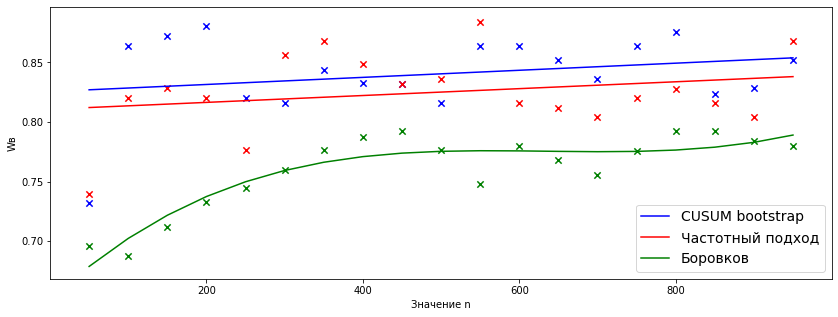

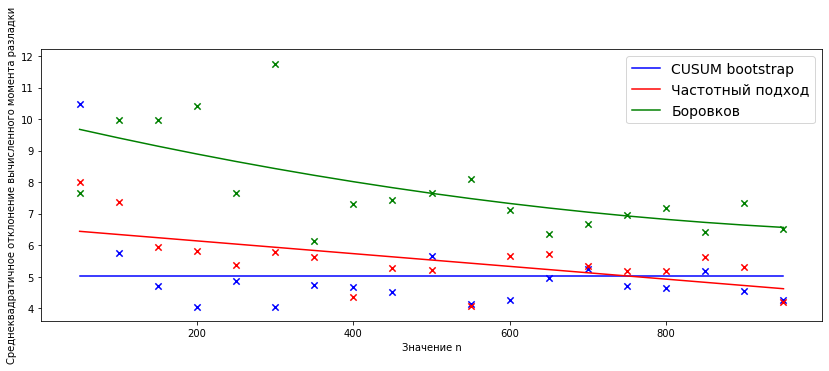

In [84]:
plt.figure(figsize=(14,5))
plt.ylabel('Wв')
plt.xlabel('Значение n')

sns.lineplot(x=lst_n, 
             y=savgol_filter(lst_cb_W1, len(lst_n), 1),
             color='blue',
             label='CUSUM bootstrap')
plt.scatter(lst_n, lst_cb_W1, color='blue', s=40, marker='x')

sns.lineplot(x=lst_n, 
             y=savgol_filter(lst_fa_W1, len(lst_n), 1),
             color='red',
             linestyle='--',
             label='Частотный подход')
plt.scatter(lst_n, lst_fa_W1, color='red', s=40, marker='x')

sns.lineplot(x=lst_n, 
             y=savgol_filter(lst_bor_W1, len(lst_n), 3),
             color='green',
             linestyle='-.',
             label='Боровков')
plt.scatter(lst_n, lst_bor_W1, color='green', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()

plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение вычисленного момента разладки')
plt.xlabel('Значение n')

sns.lineplot(x=lst_n, 
             y=savgol_filter(lst_cb_sigma, len(lst_n), 1, mode='wrap'),
             color='blue',
             label='CUSUM bootstrap')
plt.scatter(lst_n, lst_cb_sigma, color='blue', s=40, marker='x')

sns.lineplot(x=lst_n, 
             y=savgol_filter(lst_fa_sigma, len(lst_n), 1),
             color='red',
             linestyle='--',
             label='Частотный подход')
plt.scatter(lst_n, lst_fa_sigma, color='red', s=40, marker='x')

sns.lineplot(x=lst_n, 
             y=savgol_filter(lst_bor_sigma, len(lst_n), 2),
             color='green',
             linestyle='-.',
             label='Боровков')
plt.scatter(lst_n, lst_bor_sigma, color='green', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()


# Поведение алгоритмов в зависимости от позиции разладки (м1)

In [105]:
%%time
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_cb_sigma = []
# При различных значениях θ
lst_theta = [a for a in range(100, 1000, 100)]
seq_len = 1000
N = 250
N_bootstrap = 10000

# Показатели W1
lst_cb_W1 = []

# Показатели K1
k1 = 5

for theta in lst_theta:
    # Для алгоритма кусьюм
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=seq_len,
            mean=1, 
            standard_deviation=1,
            change_point_position=theta,
            mean_change=1
        )

        result = algorithm_CUSUM_bootstrap(seq=sequence)
        lst.append(result)
    

    W_1 = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap): 
        W_1 += calculate_W(k1, sample, CP=theta)
        std_time += np.std(sample)
        
    W_1 = W_1 / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_cb_W1.append(W_1)
    lst_cb_sigma.append(std_time)

Wall time: 31min 13s


In [106]:
%%time
# Показатели W1
lst_fa_W1 = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_fa_sigma = []

for theta in lst_theta:    
    # Для частотного подхода
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=seq_len,
            mean=1, 
            standard_deviation=1,
            change_point_position=theta,
            mean_change=1
        )

        result = algorithm_fa(seq=sequence)
        lst.append(result)
        
    W_1 = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap): 
        W_1 += calculate_W(k1, sample, CP=theta)
        std_time += np.std(sample)
        
    W_1 = W_1 / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_fa_W1.append(W_1)
    lst_fa_sigma.append(std_time)

Wall time: 11min 43s


In [107]:
%%time
# Показатели среднего времени запаздывания
lst_bor_W1 = []
# Показатели среднеквадратичного отклонения времени запаздывания обнаружения
lst_bor_sigma = []

for theta in lst_theta:    
    # Для Боровкова
    lst = []
    for i in range(N):    
        sequence = ChagePointMean(
            N=seq_len,
            mean=1, 
            standard_deviation=1,
            change_point_position=theta,
            mean_change=1
        )

        result = algorithm_change_point_Q(seq=sequence)
        lst.append(result)
        
    W_1 = 0
    # Считаем среднеквадратичное отклонение с помощью бутстрэпа
    std_time = 0
    for sample in get_bootstrap_samples(lst, N_bootstrap): 
        W_1 += calculate_W(k1, sample, CP=theta)
        std_time += np.std(sample)
        
    W_1 = W_1 / N_bootstrap
    std_time = std_time / N_bootstrap
    
    lst_bor_W1.append(W_1)
    lst_bor_sigma.append(std_time)

C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\TryUserPWNZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in double_scalars


Wall time: 3h 10min 38s


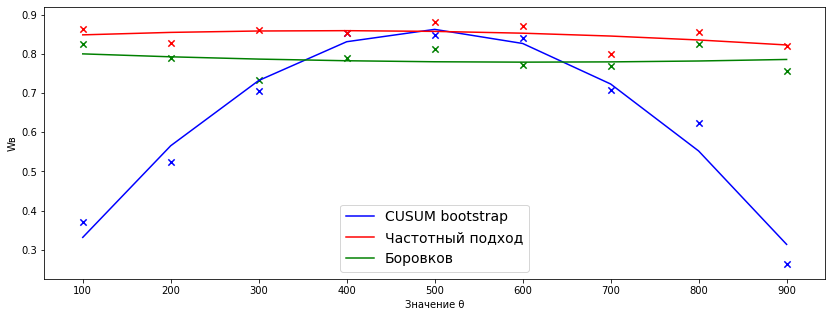

In [134]:
plt.figure(figsize=(14,5))
plt.ylabel('Wв')
plt.xlabel('Значение θ')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_cb_W1, len(lst_theta), 2),
             color='blue',
             label='CUSUM bootstrap')
plt.scatter(lst_theta, lst_cb_W1, color='blue', s=40, marker='x')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_fa_W1, len(lst_theta), 2),
             color='red',
             linestyle='--',
             label='Частотный подход')
plt.scatter(lst_theta, lst_fa_W1, color='red', s=40, marker='x')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_bor_W1, len(lst_theta), 2),
             color='green',
             linestyle='-.',
             label='Боровков')
plt.scatter(lst_theta, lst_bor_W1, color='green', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()



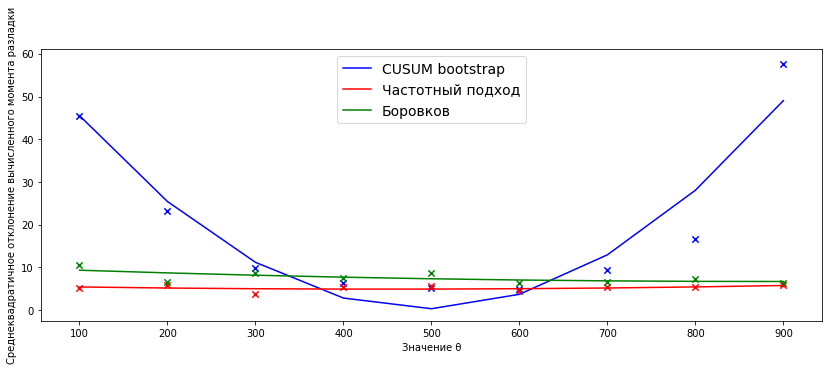

In [137]:
plt.figure(figsize=(14,5))
plt.ylabel('Среднеквадратичное отклонение вычисленного момента разладки')
plt.xlabel('Значение θ')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_cb_sigma, len(lst_theta), 2 ), # mode='wrap'
             color='blue',
             label='CUSUM bootstrap')
plt.scatter(lst_theta, lst_cb_sigma, color='blue', s=40, marker='x')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_fa_sigma, len(lst_theta), 2),
             color='red',
             linestyle='--',
             label='Частотный подход')
plt.scatter(lst_theta, lst_fa_sigma, color='red', s=40, marker='x')

sns.lineplot(x=lst_theta, 
             y=savgol_filter(lst_bor_sigma, len(lst_theta), 2),
             color='green',
             linestyle='-.',
             label='Боровков')
plt.scatter(lst_theta, lst_bor_sigma, color='green', s=40, marker='x')

plt.legend(fontsize=14) 
plt.show()
